# ライブラリのインストール

In [2]:
#@title ライブラリのインストール

print("Downloading CLIP...")
!git clone https://github.com/openai/CLIP

print("Downloading Python AI libraries...")
!git clone https://github.com/CompVis/taming-transformers
!pip install ftfy regex tqdm omegaconf pytorch-lightning
!pip install kornia
!pip install einops
!pip install keybert

print("Installing libraries for handling metadata...")
!pip install stegano
!apt install exempi
!pip install python-xmp-toolkit
!pip install imgtag
!pip install pillow==7.1.2
 
print("Installing Python video creation libraries...")
!pip install imageio-ffmpeg
print("Installing Google-API libraries...")
!pip install git+https://github.com/alainrouillon/py-googletrans@feature/enhance-use-of-direct-api
path = '/Users/hanyanoriaki/Desktop/vqgan_clip/steps'
!mkdir --parents {path}
print("Installation finished.")

fatal: destination path 'CLIP' already exists and is not an empty directory.
fatal: destination path 'taming-transformers' already exists and is not an empty directory.


Installing libraries for handling metadata...
  Using cached Pillow-9.1.1-cp38-cp38-macosx_10_10_x86_64.whl (3.1 MB)
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
The operation couldn’t be completed. Unable to locate a Java Runtime that supports apt.
Please visit http://www.java.com for information on installing Java.

  Using cached Pillow-7.1.2-cp38-cp38-macosx_10_10_x86_64.whl (2.2 MB)
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.1.1
    Uninstalling Pillow-9.1.1:
      Successfully uninstalled Pillow-9.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
stegano 0.10.2 requires pillow<10.0.0,>=9.0.0, but you have pillow 7.1.2 which is incompatible.
Installing Python video creation libraries...
mkdir: illegal option -- -
usage:

In [2]:
#@title ライブラリのインポート

import argparse
import math
from pathlib import Path
import sys
import os
import cv2
import pandas as pd
import numpy as np
import subprocess
import ast
import shutil
 
sys.path.append('/Users/hanyanoriaki/Desktop/vqgan_clip/taming-transformers')

# Some models include transformers, others need explicit pip install
try:
    import transformers
except Exception:
    !pip install transformers
    import transformers

from IPython import display
from base64 import b64encode
from omegaconf import OmegaConf
from PIL import Image
from taming.models import cond_transformer, vqgan
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm
 
from CLIP import clip
import kornia.augmentation as K
import numpy as np
import imageio
from PIL import ImageFile, Image
from imgtag import ImgTag    # metadata 
from libxmp import *         # metadata
import libxmp                # metadata
from stegano import lsb
import json
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
#@title Workspace作成

!mkdir '/content/Workspace/vqgan'
!mkdir '/content/Workspace/vqgan/images'
working_dir = '/content/Workspace/vqgan'

In [25]:
#@title 関数定義

def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))
 
 
def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()
 
 
def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]
 
 
def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size
 
    input = input.view([n * c, 1, h, w])
 
    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])
 
    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])
 
    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)
 
 
class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward
 
    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)
 
 
replace_grad = ReplaceGrad.apply
 
 
class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)
 
    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None
 
 
clamp_with_grad = ClampWithGrad.apply
 
 
def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)
 
 
class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))
 
    def forward(self, input):
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize(self.embed.unsqueeze(0), dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()
 
 
def parse_prompt(prompt):
    vals = prompt.rsplit(':', 2)
    vals = vals + ['', '1', '-inf'][len(vals):]
    return vals[0], float(vals[1]), float(vals[2])
 
 
class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow
        self.augs = nn.Sequential(
            K.RandomHorizontalFlip(p=0.5),
            # K.RandomSolarize(0.01, 0.01, p=0.7),
            K.RandomSharpness(0.3,p=0.4),
            K.RandomAffine(degrees=30, translate=0.1, p=0.8, padding_mode='border'),
            K.RandomPerspective(0.2,p=0.4),
            K.ColorJitter(hue=0.01, saturation=0.01, p=0.7))
        self.noise_fac = 0.1
 
 
    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))
        batch = self.augs(torch.cat(cutouts, dim=0))
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch
 
 
def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model

def resize_image(image, out_size):
    ratio = image.size[0] / image.size[1]
    area = min(image.size[0] * image.size[1], out_size[0] * out_size[1])
    size = round((area * ratio)**0.5), round((area / ratio)**0.5)
    return image.resize(size, Image.LANCZOS)

In [28]:
#@title キーフレーズの入力・英訳
#@markdown 入力例：["地球","月","太陽","海","sky"]

key_phrase = ["地球","月","太陽","海","sky"] #@param {type:"string"}


from googletrans import Translator
tr = Translator(service_urls=['translate.googleapis.com'])

en_key_phrase_list = []
for src in key_phrase:
    while True:
        try:
            text = tr.translate(src, dest="en").text
            break
        except Exception as e:
            tr = Translator(service_urls=['translate.googleapis.com'])
    en_key_phrase_list.append(text)

key_phrase_list = en_key_phrase_list
print("key_phrase : ",en_key_phrase_list)

key_phrase :  ['Earth', 'moon', 'sun', 'Sea', 'sky']


In [30]:
#@title スタイルの選択

import random

art_style = ' in vray unreal engine hyperrealistic' #@param [' in vray unreal engine hyperrealistic', ' in Ghibli style', ' in Raphael style', ' in banksy style', ' in Makoto Shinkai style','your choice!']

if art_style == 'your choice!':
    art_style = "" #@param {type:"string"}


t = 30 #@param {type:"number"}
w = int(t*6/6)

#text_prompts
text_prompts_list = ["'",key_phrase_list[3],art_style,"'",':{0: 0, ',str(w),': 1}, ',
                     "'",key_phrase_list[1],art_style,"'",':{',str(w),': 0 ',",", str(w*2),': 1}, ',
                     "'",key_phrase_list[0],art_style,"'",':{',str(w*2),': 0 ',",", str(w*3),': 1}, ',
                     "'",key_phrase_list[4],art_style,"'",':{',str(w*3),': 0 ',",", str(w*4),': 1}, ',
                     "'",key_phrase_list[2],art_style,"'",':{',str(w*4),': 0 ',",", str(w*5),': 1}']

tmp_text_prompts = "".join(text_prompts_list)

#angle
angles = random.sample([15,30,45,90,180,360], 5)

tmp_angle_list = ['0',':0, ',str(int(w/2)),':',str(angles[0]),', ',str(w),':', str(-angles[0]),', ',
                  str(int(w+w/2)),':',str(angles[1]),', ',str(w*2),':', str(-angles[1]),', ',
                  str(int(w*2+w/2)),':',str(angles[2]),', ',str(w*3),':', str(-angles[2]),', ',
                  str(int(w*3+w/2)),':',str(angles[3]),', ', str(w*4),':', str(-angles[3]),', ',
                  str(int(w*4+w/2)),':',str(angles[4]),', ', str(w*5),':', str(-angles[4])]

tmp_angle = "".join(tmp_angle_list)

#zoom
zoom_in = random.sample([1,1.25,1.5,1.75,2], 5)
zoom_out = random.sample([0.5,0.625,0.75,0.875,1], 5)

tmp_zoom_list = ['0',':1, ',str(int(w/2)),':',str(zoom_in[0]),', ',str(w),':', str(zoom_out[0]),', ',
                 str(int(w+w/2)),':',str(zoom_in[1]),', ',str(w*2),':', str(zoom_out[1]),', ',
                 str(int(w*2+w/2)),':',str(zoom_in[2]),', ',str(w*3),':', str(zoom_out[2]),', ',
                 str(int(w*3+w/2)),':',str(zoom_in[3]),', ', str(w*4),':', str(zoom_out[3]),', ',
                 str(int(w*4+w/2)),':',str(zoom_in[4]),', ', str(w*5),':', str(zoom_out[4])]

tmp_zoom = "".join(tmp_zoom_list)

# パラメータ設定

In [6]:
key_frames = True
text_prompts = tmp_text_prompts
width =  400
height =  400
model = "vqgan_imagenet_f16_16384"
interval =  1
initial_image = ""
target_images = ""
seed = -1
max_frames = t*5
angle = tmp_angle

# @markdown <b>Careful:</b> do not use negative or 0 zoom. If you want to zoom out, use a number between 0 and 1.
zoom = tmp_zoom
translation_x = "0: 0"
translation_y = "0: 0"
iterations_per_frame = "0: 10"
save_all_iterations = False

# option -C - skips download if already exists
!curl -C - -L -o {model}.yaml -C - 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #ImageNet 1024
!curl -C - -L -o {model}.ckpt -C - 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fckpts%2Flast.ckpt&dl=1'  #ImageNet 1024

if initial_image != "":
    print(
        "WARNING: You have specified an initial image. Note that the image resolution "
        "will be inherited from this image, not whatever width and height you specified. "
        "If the initial image resolution is too high, this can result in out of memory errors."
    )
elif width * height > 160000:
    print(
        "WARNING: The width and height you have specified may be too high, in which case "
        "you will encounter out of memory errors either at the image generation stage or the "
        "video synthesis stage. If so, try reducing the resolution"
    )
model_names={
    "vqgan_imagenet_f16_16384": 'ImageNet 16384',
    "vqgan_imagenet_f16_1024":"ImageNet 1024", 
    "wikiart_1024":"WikiArt 1024",
    "wikiart_16384":"WikiArt 16384",
    "coco":"COCO-Stuff",
    "faceshq":"FacesHQ",
    "sflckr":"S-FLCKR"
}
model_name = model_names[model]

if seed == -1:
    seed = None

def parse_key_frames(string, prompt_parser=None):
    """Given a string representing frame numbers paired with parameter values at that frame,
    return a dictionary with the frame numbers as keys and the parameter values as the values.

    Parameters
    ----------
    string: string
        Frame numbers paired with parameter values at that frame number, in the format
        'framenumber1: (parametervalues1), framenumber2: (parametervalues2), ...'
    prompt_parser: function or None, optional
        If provided, prompt_parser will be applied to each string of parameter values.
    
    Returns
    -------
    dict
        Frame numbers as keys, parameter values at that frame number as values

    Raises
    ------
    RuntimeError
        If the input string does not match the expected format.
    
    Examples
    --------
    >>> parse_key_frames("10:(Apple: 1| Orange: 0), 20: (Apple: 0| Orange: 1| Peach: 1)")
    {10: 'Apple: 1| Orange: 0', 20: 'Apple: 0| Orange: 1| Peach: 1'}

    >>> parse_key_frames("10:(Apple: 1| Orange: 0), 20: (Apple: 0| Orange: 1| Peach: 1)", prompt_parser=lambda x: x.lower()))
    {10: 'apple: 1| orange: 0', 20: 'apple: 0| orange: 1| peach: 1'}
    """

    try:
        # This is the preferred way, the regex way will eventually be deprecated.
        frames = ast.literal_eval('{' + string + '}')
        if isinstance(frames, set):
            # If user forgot keyframes, just set value of frame 0
            (frame,) = list(frames)
            frames = {0: frame}
        return frames
    except Exception:
        import re
        pattern = r'((?P<frame>[0-9]+):[\s]*[\(](?P<param>[\S\s]*?)[\)])'
        frames = dict()
        for match_object in re.finditer(pattern, string):
            frame = int(match_object.groupdict()['frame'])
            param = match_object.groupdict()['param']
            if prompt_parser:
                frames[frame] = prompt_parser(param)
            else:
                frames[frame] = param

        if frames == {} and len(string) != 0:
            raise RuntimeError(f'Key Frame string not correctly formatted: {string}')
        return frames

# Defaults, if left empty
if angle == "":
    angle = "0"
if zoom == "":
    zoom = "1"
if translation_x == "":
    translation_x = "0"
if translation_y == "":
    translation_y = "0"
if iterations_per_frame == "":
    iterations_per_frame = "10"

if key_frames:
    parameter_dicts = dict()
    parameter_dicts['zoom'] = parse_key_frames(zoom, prompt_parser=float)
    parameter_dicts['angle'] = parse_key_frames(angle, prompt_parser=float)
    parameter_dicts['translation_x'] = parse_key_frames(translation_x, prompt_parser=float)
    parameter_dicts['translation_y'] = parse_key_frames(translation_y, prompt_parser=float)
    parameter_dicts['iterations_per_frame'] = parse_key_frames(iterations_per_frame, prompt_parser=int)

    text_prompts_dict = parse_key_frames(text_prompts)
    if all([isinstance(value, dict) for value in list(text_prompts_dict.values())]):
        for key, value in list(text_prompts_dict.items()):
            parameter_dicts[f'text_prompt: {key}'] = value
    else:
        # Old format
        text_prompts_dict = parse_key_frames(text_prompts, prompt_parser=lambda x: x.split('|'))
        for frame, prompt_list in text_prompts_dict.items():
            for prompt in prompt_list:
                prompt_key, prompt_value = prompt.split(":")
                prompt_key = f'text_prompt: {prompt_key.strip()}'
                prompt_value = prompt_value.strip()
                if prompt_key not in parameter_dicts:
                    parameter_dicts[prompt_key] = dict()
                parameter_dicts[prompt_key][frame] = prompt_value


    image_prompts_dict = parse_key_frames(target_images)
    if all([isinstance(value, dict) for value in list(image_prompts_dict.values())]):
        for key, value in list(image_prompts_dict.items()):
            parameter_dicts[f'image_prompt: {key}'] = value
    else:
        # Old format
        image_prompts_dict = parse_key_frames(target_images, prompt_parser=lambda x: x.split('|'))
        print(image_prompts_dict)
        for frame, prompt_list in image_prompts_dict.items():
            for prompt in prompt_list:
                prompt_key, prompt_value = prompt.split(":")
                prompt_key = f'image_prompt: {prompt_key.strip()}'
                prompt_value = prompt_value.strip()
                if prompt_key not in parameter_dicts:
                    parameter_dicts[prompt_key] = dict()
                parameter_dicts[prompt_key][frame] = prompt_value


def add_inbetweens():
    global text_prompts
    global target_images
    global zoom
    global angle
    global translation_x
    global translation_y
    global iterations_per_frame

    global text_prompts_series
    global target_images_series
    global zoom_series
    global angle_series
    global translation_x_series
    global translation_y_series
    global iterations_per_frame_series
    global model
    global args
    def get_inbetweens(key_frames_dict, integer=False):
        """Given a dict with frame numbers as keys and a parameter value as values,
        return a pandas Series containing the value of the parameter at every frame from 0 to max_frames.
        Any values not provided in the input dict are calculated by linear interpolation between
        the values of the previous and next provided frames. If there is no previous provided frame, then
        the value is equal to the value of the next provided frame, or if there is no next provided frame,
        then the value is equal to the value of the previous provided frame. If no frames are provided,
        all frame values are NaN.

        Parameters
        ----------
        key_frames_dict: dict
            A dict with integer frame numbers as keys and numerical values of a particular parameter as values.
        integer: Bool, optional
            If True, the values of the output series are converted to integers.
            Otherwise, the values are floats.
        
        Returns
        -------
        pd.Series
            A Series with length max_frames representing the parameter values for each frame.
        
        Examples
        --------
        >>> max_frames = 5
        >>> get_inbetweens({1: 5, 3: 6})
        0    5.0
        1    5.0
        2    5.5
        3    6.0
        4    6.0
        dtype: float64

        >>> get_inbetweens({1: 5, 3: 6}, integer=True)
        0    5
        1    5
        2    5
        3    6
        4    6
        dtype: int64
        """
        key_frame_series = pd.Series([np.nan for a in range(max_frames)])
        for i, value in key_frames_dict.items():
            key_frame_series[i] = value
        key_frame_series = key_frame_series.astype(float)
        key_frame_series = key_frame_series.interpolate(limit_direction='both')
        if integer:
            return key_frame_series.astype(int)
        return key_frame_series

    if key_frames:
        text_prompts_series_dict = dict()
        for parameter in parameter_dicts.keys():
            if len(parameter_dicts[parameter]) > 0:
                if parameter.startswith('text_prompt:'):
                    try:
                        text_prompts_series_dict[parameter] = get_inbetweens(parameter_dicts[parameter])
                    except RuntimeError as e:
                        raise RuntimeError(
                            "WARNING: You have selected to use key frames, but you have not "
                            "formatted `text_prompts` correctly for key frames.\n"
                            "Please read the instructions to find out how to use key frames "
                            "correctly.\n"
                        )
        text_prompts_series = pd.Series([np.nan for a in range(max_frames)])
        for i in range(max_frames):
            combined_prompt = []
            for parameter, value in text_prompts_series_dict.items():
                parameter = parameter[len('text_prompt:'):].strip()
                combined_prompt.append(f'{parameter}: {value[i]}')
            text_prompts_series[i] = ' | '.join(combined_prompt)

        image_prompts_series_dict = dict()
        for parameter in parameter_dicts.keys():
            if len(parameter_dicts[parameter]) > 0:
                if parameter.startswith('image_prompt:'):
                    try:
                        image_prompts_series_dict[parameter] = get_inbetweens(parameter_dicts[parameter])
                    except RuntimeError as e:
                        raise RuntimeError(
                            "WARNING: You have selected to use key frames, but you have not "
                            "formatted `image_prompts` correctly for key frames.\n"
                            "Please read the instructions to find out how to use key frames "
                            "correctly.\n"
                        )
        target_images_series = pd.Series([np.nan for a in range(max_frames)])
        for i in range(max_frames):
            combined_prompt = []
            for parameter, value in image_prompts_series_dict.items():
                parameter = parameter[len('image_prompt:'):].strip()
                combined_prompt.append(f'{parameter}: {value[i]}')
            target_images_series[i] = ' | '.join(combined_prompt)

        try:
            angle_series = get_inbetweens(parameter_dicts['angle'])
        except RuntimeError as e:
            print(
                "WARNING: You have selected to use key frames, but you have not "
                "formatted `angle` correctly for key frames.\n"
                "Attempting to interpret `angle` as "
                f'"0: ({angle})"\n'
                "Please read the instructions to find out how to use key frames "
                "correctly.\n"
            )
            angle = f"0: ({angle})"
            angle_series = get_inbetweens(parse_key_frames(angle))

        try:
            zoom_series = get_inbetweens(parameter_dicts['zoom'])
        except RuntimeError as e:
            print(
                "WARNING: You have selected to use key frames, but you have not "
                "formatted `zoom` correctly for key frames.\n"
                "Attempting to interpret `zoom` as "
                f'"0: ({zoom})"\n'
                "Please read the instructions to find out how to use key frames "
                "correctly.\n"
            )
            zoom = f"0: ({zoom})"
            zoom_series = get_inbetweens(parse_key_frames(zoom))
        for i, zoom in enumerate(zoom_series):
            if zoom <= 0:
                print(
                    f"WARNING: You have selected a zoom of {zoom} at frame {i}. "
                    "This is meaningless. "
                    "If you want to zoom out, use a value between 0 and 1. "
                    "If you want no zoom, use a value of 1."
                )

        try:
            translation_x_series = get_inbetweens(parameter_dicts['translation_x'])
        except RuntimeError as e:
            print(
                "WARNING: You have selected to use key frames, but you have not "
                "formatted `translation_x` correctly for key frames.\n"
                "Attempting to interpret `translation_x` as "
                f'"0: ({translation_x})"\n'
                "Please read the instructions to find out how to use key frames "
                "correctly.\n"
            )
            translation_x = f"0: ({translation_x})"
            translation_x_series = get_inbetweens(parse_key_frames(translation_x))

        try:
            translation_y_series = get_inbetweens(parameter_dicts['translation_y'])
        except RuntimeError as e:
            print(
                "WARNING: You have selected to use key frames, but you have not "
                "formatted `translation_y` correctly for key frames.\n"
                "Attempting to interpret `translation_y` as "
                f'"0: ({translation_y})"\n'
                "Please read the instructions to find out how to use key frames "
                "correctly.\n"
            )
            translation_y = f"0: ({translation_y})"
            translation_y_series = get_inbetweens(parse_key_frames(translation_y))

        try:
            iterations_per_frame_series = get_inbetweens(
                parameter_dicts['iterations_per_frame'], integer=True
            )
        except RuntimeError as e:
            print(
                "WARNING: You have selected to use key frames, but you have not "
                "formatted `iterations_per_frame` correctly for key frames.\n"
                "Attempting to interpret `iterations_per_frame` as "
                f'"0: ({iterations_per_frame})"\n'
                "Please read the instructions to find out how to use key frames "
                "correctly.\n"
            )
            iterations_per_frame = f"0: ({iterations_per_frame})"
            
            iterations_per_frame_series = get_inbetweens(
                parse_key_frames(iterations_per_frame), integer=True
            )
    else:
        text_prompts = [phrase.strip() for phrase in text_prompts.split("|")]
        if text_prompts == ['']:
            text_prompts = []
        if target_images == "None" or not target_images:
            target_images = []
        else:
            target_images = target_images.split("|")
            target_images = [image.strip() for image in target_images]

        angle = float(angle)
        zoom = float(zoom)
        translation_x = float(translation_x)
        translation_y = float(translation_y)
        iterations_per_frame = int(iterations_per_frame)
        if zoom <= 0:
            print(
                f"WARNING: You have selected a zoom of {zoom}. "
                "This is meaningless. "
                "If you want to zoom out, use a value between 0 and 1. "
                "If you want no zoom, use a value of 1."
            )

    args = argparse.Namespace(
        prompts=text_prompts,
        image_prompts=target_images,
        noise_prompt_seeds=[],
        noise_prompt_weights=[],
        size=[width, height],
        init_weight=0.,
        clip_model='ViT-B/32',
        vqgan_config=f'{model}.yaml',
        vqgan_checkpoint=f'{model}.ckpt',
        step_size=0.1,
        cutn=64,
        cut_pow=1.,
        display_freq=interval,
        seed=seed,
    )

add_inbetweens()

print("done!")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
** Resuming transfer from byte position 645
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
zsh:1: command not found: nvidia-smi
Using device: cpu
Using seed: 1
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt
text_prompts: ['sky: 0.0', 'wind: 0.0', 'sadness: 0.0', 'blown: 0.0', 'died: 0.0'] image_prompts: [] angle: 0.0 zoom: 1.0 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 10


0it [00:00, ?it/s]

point6-s
point6-f
i: 1, loss: 0, losses: 0, 0, 0, 0, 0
point6-s
point6-f


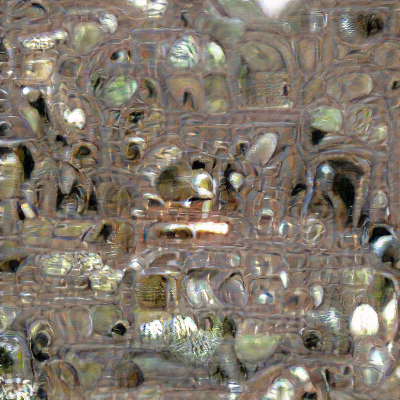

text_prompts: ['sky: 0.0', 'wind: 0.0', 'sadness: 0.0', 'blown: 0.0', 'died: 0.0'] image_prompts: [] angle: 0.0 zoom: 1.0 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 10


0it [00:00, ?it/s]

point6-s
point6-f
i: 2, loss: 0, losses: 0, 0, 0, 0, 0
point6-s
point6-f


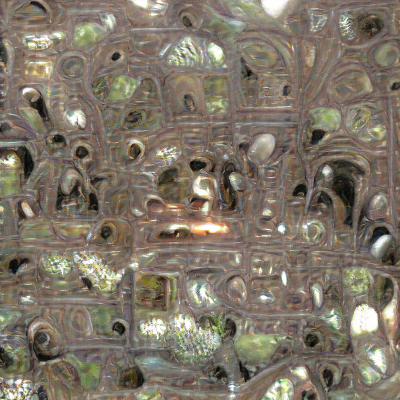

text_prompts: ['sky: 0.0', 'wind: 0.0', 'sadness: 0.0', 'blown: 0.0', 'died: 0.0'] image_prompts: [] angle: 0.0 zoom: 1.0 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 10


0it [00:00, ?it/s]

done!


In [16]:
#@title 画像生成

path = f'{working_dir}/steps/org'
shutil.rmtree(path)
os.mkdir(path)

# Delete memory from previous runs
!nvidia-smi -caa
for var in ['device', 'model', 'perceptor', 'z']:
  try:
      del globals()[var]
  except:
      pass

try:
    import gc
    gc.collect()
except:
    pass

try:
    torch.cuda.empty_cache()
except:
    pass

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if not key_frames:
    if text_prompts:
        print('Using text prompts:', text_prompts)
    if target_images:
        print('Using image prompts:', target_images)
if args.seed is None:
    seed = torch.seed()
else:
    seed = args.seed
torch.manual_seed(seed)
print('Using seed:', seed)
 
model = load_vqgan_model(args.vqgan_config, args.vqgan_checkpoint).to(device)
perceptor = clip.load(args.clip_model, jit=False)[0].eval().requires_grad_(False).to(device)
 
cut_size = perceptor.visual.input_resolution
e_dim = model.quantize.e_dim
f = 2**(model.decoder.num_resolutions - 1)
make_cutouts = MakeCutouts(cut_size, args.cutn, cut_pow=args.cut_pow)
n_toks = model.quantize.n_e
toksX, toksY = args.size[0] // f, args.size[1] // f
sideX, sideY = toksX * f, toksY * f
z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]
stop_on_next_loop = False  # Make sure GPU memory doesn't get corrupted from cancelling the run mid-way through, allow a full frame to complete

def read_image_workaround(path):
    """OpenCV reads images as BGR, Pillow saves them as RGB. Work around
    this incompatibility to avoid colour inversions."""
    im_tmp = cv2.imread(path)
    return cv2.cvtColor(im_tmp, cv2.COLOR_BGR2RGB)

for i in range(max_frames):
    if stop_on_next_loop:
      break
    if key_frames:
        text_prompts = text_prompts_series[i]
        text_prompts = [phrase.strip() for phrase in text_prompts.split("|")]
        if text_prompts == ['']:
            text_prompts = []
        args.prompts = text_prompts

        target_images = target_images_series[i]

        if target_images == "None" or not target_images:
            target_images = []
        else:
            target_images = target_images.split("|")
            target_images = [image.strip() for image in target_images]
        args.image_prompts = target_images

        angle = angle_series[i]
        zoom = zoom_series[i]
        translation_x = translation_x_series[i]
        translation_y = translation_y_series[i]
        iterations_per_frame = iterations_per_frame_series[i]
        print(
            f'text_prompts: {text_prompts}',
            f'image_prompts: {target_images}',
            f'angle: {angle}',
            f'zoom: {zoom}',
            f'translation_x: {translation_x}',
            f'translation_y: {translation_y}',
            f'iterations_per_frame: {iterations_per_frame}'
        )
    try:
        if i == 0 and initial_image != "":
            img_0 = read_image_workaround(initial_image)
            z, *_ = model.encode(TF.to_tensor(img_0).to(device).unsqueeze(0) * 2 - 1)
        elif i == 0 and not os.path.isfile(f'{working_dir}/steps/{i:04d}.png'):
            one_hot = F.one_hot(
                torch.randint(n_toks, [toksY * toksX], device=device), n_toks
            ).float()
            z = one_hot @ model.quantize.embedding.weight
            z = z.view([-1, toksY, toksX, e_dim]).permute(0, 3, 1, 2)
        else:
            if save_all_iterations:
                img_0 = read_image_workaround(
                    f'{working_dir}/steps/{i:04d}_{iterations_per_frame}.png')
            else:
                img_0 = read_image_workaround(f'{working_dir}/steps/{i:04d}.png')

            center = (1*img_0.shape[1]//2, 1*img_0.shape[0]//2)
            trans_mat = np.float32(
                [[1, 0, translation_x],
                [0, 1, translation_y]]
            )
            rot_mat = cv2.getRotationMatrix2D( center, angle, zoom )

            trans_mat = np.vstack([trans_mat, [0,0,1]])
            rot_mat = np.vstack([rot_mat, [0,0,1]])
            transformation_matrix = np.matmul(rot_mat, trans_mat)

            img_0 = cv2.warpPerspective(
                img_0,
                transformation_matrix,
                (img_0.shape[1], img_0.shape[0]),
                borderMode=cv2.BORDER_WRAP
            )
            z, *_ = model.encode(TF.to_tensor(img_0).to(device).unsqueeze(0) * 2 - 1)
        i += 1

        z_orig = z.clone()
        z.requires_grad_(True)
        opt = optim.Adam([z], lr=args.step_size)

        normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                        std=[0.26862954, 0.26130258, 0.27577711])

        pMs = []

        for prompt in args.prompts:
            txt, weight, stop = parse_prompt(prompt)
            embed = perceptor.encode_text(clip.tokenize(txt).to(device)).float()
            pMs.append(Prompt(embed, weight, stop).to(device))

        for prompt in args.image_prompts:
            path, weight, stop = parse_prompt(prompt)
            img = resize_image(Image.open(path).convert('RGB'), (sideX, sideY))
            batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(device))
            embed = perceptor.encode_image(normalize(batch)).float()
            pMs.append(Prompt(embed, weight, stop).to(device))

        for seed, weight in zip(args.noise_prompt_seeds, args.noise_prompt_weights):
            gen = torch.Generator().manual_seed(seed)
            embed = torch.empty([1, perceptor.visual.output_dim]).normal_(generator=gen)
            pMs.append(Prompt(embed, weight).to(device))

        def synth(z):
            z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
            return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

        def add_xmp_data(filename):
            imagen = ImgTag(filename=filename)
            imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'creator', 'VQGAN+CLIP', {"prop_array_is_ordered":True, "prop_value_is_array":True})
            if args.prompts:
                imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'title', " | ".join(args.prompts), {"prop_array_is_ordered":True, "prop_value_is_array":True})
            else:
                imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'title', 'None', {"prop_array_is_ordered":True, "prop_value_is_array":True})
            imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'i', str(i), {"prop_array_is_ordered":True, "prop_value_is_array":True})
            imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'model', model_name, {"prop_array_is_ordered":True, "prop_value_is_array":True})
            imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'seed',str(seed) , {"prop_array_is_ordered":True, "prop_value_is_array":True})
            imagen.close()

        def add_stegano_data(filename):
            data = {
                "title": " | ".join(args.prompts) if args.prompts else None,
                "notebook": "VQGAN+CLIP",
                "i": i,
                "model": model_name,
                "seed": str(seed),
            }
            lsb.hide(filename, json.dumps(data)).save(filename)

        @torch.no_grad()
        def checkin(i, losses):
            losses_str = ', '.join(f'{loss.item():g}' for loss in losses)
            tqdm.write(f'i: {i}, loss: {sum(losses).item():g}, losses: {losses_str}')
            out = synth(z)
            TF.to_pil_image(out[0].cpu()).save('progress.png')
            add_stegano_data('progress.png')
            add_xmp_data('progress.png')
            display.display(display.Image('progress.png'))

        def save_output(i, img, suffix=None):
            filename = \
                f"{working_dir}/steps/{i:04}{'_' + suffix if suffix else ''}.png"
            imageio.imwrite(filename, np.array(img))
            add_stegano_data(filename)
            add_xmp_data(filename)

        def ascend_txt(i, save=True, suffix=None):
            out = synth(z)
            iii = perceptor.encode_image(normalize(make_cutouts(out))).float()

            result = []

            if args.init_weight:
                result.append(F.mse_loss(z, z_orig) * args.init_weight / 2)

            for prompt in pMs:
                result.append(prompt(iii))
            img = np.array(out.mul(255).clamp(0, 255)[0].cpu().detach().numpy().astype(np.uint8))[:,:,:]
            img = np.transpose(img, (1, 2, 0))
            if save:
                save_output(i, img, suffix=suffix)
            return result

        def train(i, save=True, suffix=None):
            opt.zero_grad()
            lossAll = ascend_txt(i, save=save, suffix=suffix)
            if i % args.display_freq == 0 and save:
                checkin(i, lossAll)
            loss = sum(lossAll)
            loss.backward()
            opt.step()
            with torch.no_grad():
                z.copy_(z.maximum(z_min).minimum(z_max))

        with tqdm() as pbar:
            if iterations_per_frame == 0:
                save_output(i, img_0)
            j = 1
            while True:
                suffix = (str(j) if save_all_iterations else None)
                if j >= iterations_per_frame:
                    train(i, save=True, suffix=suffix)
                    break
                if save_all_iterations:
                    train(i, save=True, suffix=suffix)
                else:
                    train(i, save=False, suffix=suffix)
                j += 1
                pbar.update()
    except KeyboardInterrupt:
      stop_on_next_loop = True
      pass

print("done!")

In [38]:
#@title SRCNNによる超解像(Option)

!git clone https://github.com/Mirwaisse/SRCNN.git
!curl https://raw.githubusercontent.com/chigozienri/SRCNN/master/models/model_2x.pth -o model_2x.pth

# import subprocess in case this cell is run without the above cells
import subprocess
# Set zoomed = True if this cell is run
zoomed = True

init_frame = 1
last_frame = t*6

for i in range(init_frame, last_frame + 1): #
    filename = f"{i:04}.png"
    cmd = [
        'python',
        '/content/SRCNN/run.py',
        '--zoom_factor',
        '2',  # Note if you increase this, you also need to change the model.
        '--model',
        '/content/model_2x.pth',  # 2x, 3x and 4x are available from the repo above
        '--image',
        filename,
        '--cuda'
    ]
    print(f'Upscaling frame {i}')

    process = subprocess.Popen(cmd, cwd=f'{working_dir}/steps/')
    stdout, stderr = process.communicate()
    if process.returncode != 0:
        print(stderr)
        print(
            "You may be able to avoid this error by backing up the frames,"
            "restarting the notebook, and running only the video synthesis cells,"
            "or by decreasing the resolution of the image generation steps. "
            "If you restart the notebook, you will have to define the `filepath` manually"
            "by adding `filepath = 'PATH_TO_THE_VIDEO'` to the beginning of this cell. "
            "If these steps do not work, please post the traceback in the github."
        )
        raise RuntimeError(stderr)

Upscaling frame 1
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 2
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 3


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 4
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


cpu
Upscaling frame 5


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 6


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 7


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


Upscaling frame 8
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 9


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 10


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 11


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 12


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 13


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 14


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 15


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 16


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 17


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 18


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 19


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 20


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 21


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 22


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 23


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 24


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 25


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 26


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 27


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 28


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 29


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 30


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 31


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 32


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 33


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


cpu
Upscaling frame 34
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 35


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 36


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 37


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 38


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 39


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 40


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 41


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 42


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


cpu
Upscaling frame 43
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


Upscaling frame 44
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


cpu
Upscaling frame 45
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 46


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 47


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 48


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 49


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 50


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


cpu
Upscaling frame 51
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 52


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


cpu
Upscaling frame 53
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 54


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 55


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 56


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 57


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 58


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 59


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 60


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 61


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 62


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 63


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


cpu
Upscaling frame 64
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 65


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 66


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 67


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 68


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 69


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 70


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 71


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 72


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 73


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 74


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 75


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


cpu
Upscaling frame 76
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 77


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 78


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


cpu
Upscaling frame 79
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 80


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 81


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 82


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 83


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 84


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 85


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 86


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 87


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 88


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 89


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 90


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


cpu
Upscaling frame 91
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 92


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 93


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


cpu
Upscaling frame 94
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 95


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 96


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 97


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 98


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 99


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 100


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 101


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


cpu
Upscaling frame 102
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 103


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 104


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 105


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 106


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 107


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 108


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 109


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 110


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 111


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


cpu
Upscaling frame 112


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 113
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 114


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 115


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 116


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 117


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 118


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 119


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 120


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 121


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


cpu
Upscaling frame 122
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 123


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 124


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 125


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 126


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 127


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 128


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 129


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


cpu
Upscaling frame 130
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 131


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 132


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 133


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 134


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 135


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 136


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 137


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 138


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 139


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 140


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 141


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 142


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 143


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 144


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


cpu
Upscaling frame 145
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 146


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 147


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


cpu
Upscaling frame 148
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 149


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 150


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 151


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 152


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 153


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


cpu
Upscaling frame 154
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 155


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


cpu
Upscaling frame 156
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 157


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 158


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 159


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 160


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 161


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 162


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


cpu
Upscaling frame 163
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 164


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 165


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 166


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 167


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 168


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 169


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


cpu
Upscaling frame 170


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 171
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 172


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 173


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 174


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


cpu
Upscaling frame 175
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 176


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 177


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 178


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 179


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu
Upscaling frame 180


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
cpu


/Users/hanyanoriaki/Desktop/vqgan_clip/SRCNN/run.py:16: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*args.zoom_factor), int(img.size[1]*args.zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation


In [39]:
#@title アニメーション作成

# import subprocess in case this cell is run without the above cells
import subprocess

# Try to avoid OOM errors
torch.cuda.empty_cache()

init_frame = 1
last_frame = t*6
fps = 6

try:
    key_frames
except NameError:
    filename = "video.mp4"
else:
    if key_frames:
        # key frame filename would be too long
        filename = "video.mp4"
    else:
        filename = f"{'_'.join(text_prompts).replace(' ', '')}.mp4"
filepath = f'{working_dir}/{filename}'

frames = []
# tqdm.write('Generating video...')
try:
    zoomed
except NameError:
    image_path = f'{working_dir}/steps/%04d.png'
else:
    image_path = f'{working_dir}/steps/zoomed_%04d.png'

cmd = [
    'ffmpeg',
    '-y',
    '-vcodec',
    'png',
    '-r',
    str(fps),
    '-start_number',
    str(init_frame),
    '-i',
    image_path,
    '-c:v',
    'libx264',
    '-frames:v',
    str(last_frame-init_frame),
    '-vf',
    f'fps={fps}',
    '-pix_fmt',
    'yuv420p',
    '-crf',
    '17',
    '-preset',
    'veryslow',
    filepath
]

process = subprocess.Popen(cmd, cwd=f'{working_dir}/steps/', stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()
if process.returncode != 0:
    print(stderr)
    print(
        "You may be able to avoid this error by backing up the frames,"
        "restarting the notebook, and running only the google drive/local connection and video synthesis cells,"
        "or by decreasing the resolution of the image generation steps. "
        "If these steps do not work, please post the traceback in the github."
    )
    raise RuntimeError(stderr)
else:
    print("The video is ready")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Moviepy - Building video /Users/hanyanoriaki/Desktop/vqgan_clip/steps/animation/anime.mp4.
Moviepy - Writing video /Users/hanyanoriaki/Desktop/vqgan_clip/steps/animation/anime.mp4

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, 

Moviepy - Done !
Moviepy - video ready /Users/hanyanoriaki/Desktop/vqgan_clip/steps/animation/anime.mp4


In [ ]:
#@title Download as mp4

files.download(filepath)